In [1]:
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import cell2location
from matplotlib import rcParams
import os
#https://github.com/BayraktarLab/cell2location/blob/master/docs/notebooks/cell2location_tutorial.ipynb

In [2]:
results_folder = '.'
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
adata_ref = sc.read(
    f'./data/sc.h5ad', 
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad')

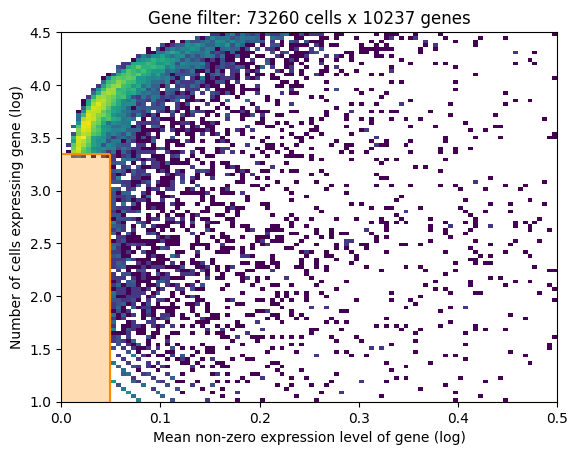

In [5]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()

In [6]:
adata_ref.var['SYMBOL'] = adata_ref.var.index 
adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)
del adata_ref.raw

In [7]:
cell2location.models.RegressionModel.setup_anndata(
    adata = adata_ref, 
    batch_key = 'Sample', 
    labels_key = 'Subset', 
    categorical_covariate_keys = ['Method']
)

In [8]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 
# view anndata_setup as a sanity check
# mod.view_anndata_setup()

In [9]:
mod.train(max_epochs=250)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [1:15:42<00:00, 18.24s/it, v_num=1, elbo_train=2.88e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [1:15:42<00:00, 18.17s/it, v_num=1, elbo_train=2.88e+8]


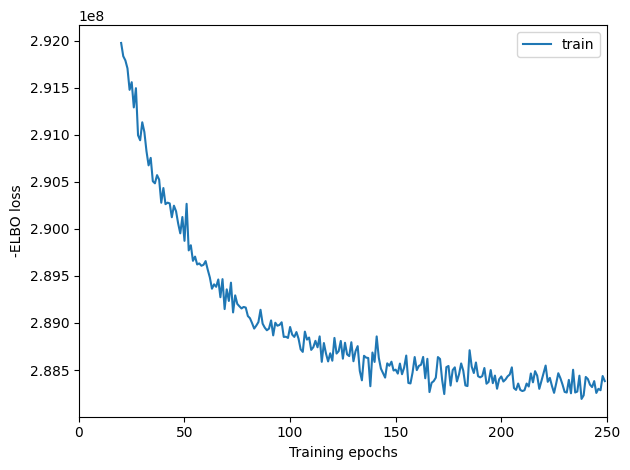

In [10]:
mod.plot_history(20)

In [13]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [01:10<00:00, 14.19it/s]


'./reference_signatures/sc.h5ad'

In [14]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN
GeneID-2,,,,,
ENSG00000188976,0.434317,0.243501,0.311626,0.347836,0.154602
ENSG00000188290,0.002042,0.000652,0.000757,0.050606,0.044101
ENSG00000187608,0.385462,0.212295,0.273449,0.506185,3.997774
ENSG00000186891,0.020364,0.000829,0.055879,0.075035,0.010210
ENSG00000186827,0.007924,0.000565,0.006403,0.031902,0.012465


### Cell2location: spatial mapping

In [15]:
h5_file = '/Users/koush/Downloads/GEX_PEX/filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(h5_file, gex_only=False)
visium_ = sc.read_visium(path=os.path.dirname(h5_file))
adata.uns['spatial'] = visium_.uns['spatial']  
adata.obsm['spatial'] = visium_.obsm['spatial']
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)        
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs["pct_counts_mt"] < 20]
adata = adata[:, adata.var["mt"] == False]
pdata = adata[:, adata.var.feature_types=='Antibody Capture']
adata = adata[:, adata.var.feature_types=='Gene Expression']
pdata.var["isotype_control"] = (pdata.var_names.str.startswith("mouse") \
    | pdata.var_names.str.startswith("rat") \
    | pdata.var_names.str.startswith("HLA"))
pdata = pdata[:, pdata.var.isotype_control==False]
adata.layers['counts'] = adata.X
pdata.layers['counts'] = pdata.X
adata.var_names_make_unique()
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
# adata = scale_adata(adata, cell_size=10)
adata

AnnData object with n_obs × n_vars = 4194 × 18074
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'counts'

In [16]:
adata_vis = adata
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [17]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata.var_names, inf_aver.index)
adata_vis = adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [18]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
) 
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.6.post2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4194  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 9520  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                                     batch State Registry                                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃                   Categories                   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ CytAssist_FFPE_Protein_Expression_Human_Tonsil │          0          │
└─────────────────────┴────────────────────────────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 30000/30000: 100%|██████████| 30000/30000 [7:28:09<00:00,  1.23it/s, v_num=1, elbo_train=6.16e+7]   

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [7:28:09<00:00,  1.12it/s, v_num=1, elbo_train=6.16e+7]


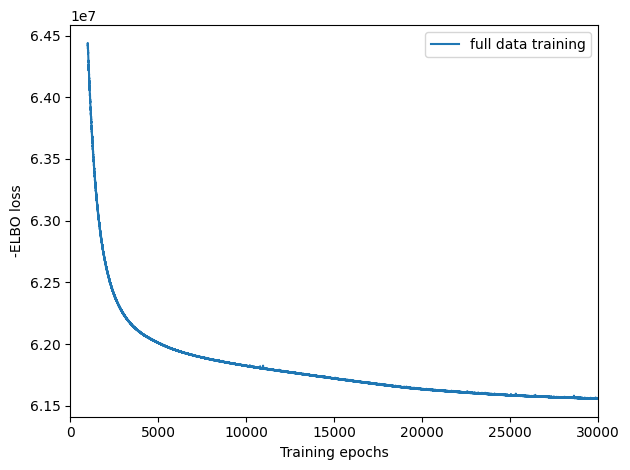

In [20]:
mod.train(max_epochs=30000, 
    # train using full data (batch_size=None)
    batch_size=None, 
    # use all data points in training because 
    # we need to estimate cell abundance at all locations
    train_size=1,
)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [21]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [01:23<00:00, 11.96it/s]


'./cell2location_map/sp.h5ad'

In [23]:
# adata_file = f"{run_name}/sp.h5ad"
# adata_vis = sc.read_h5ad(adata_file)
# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

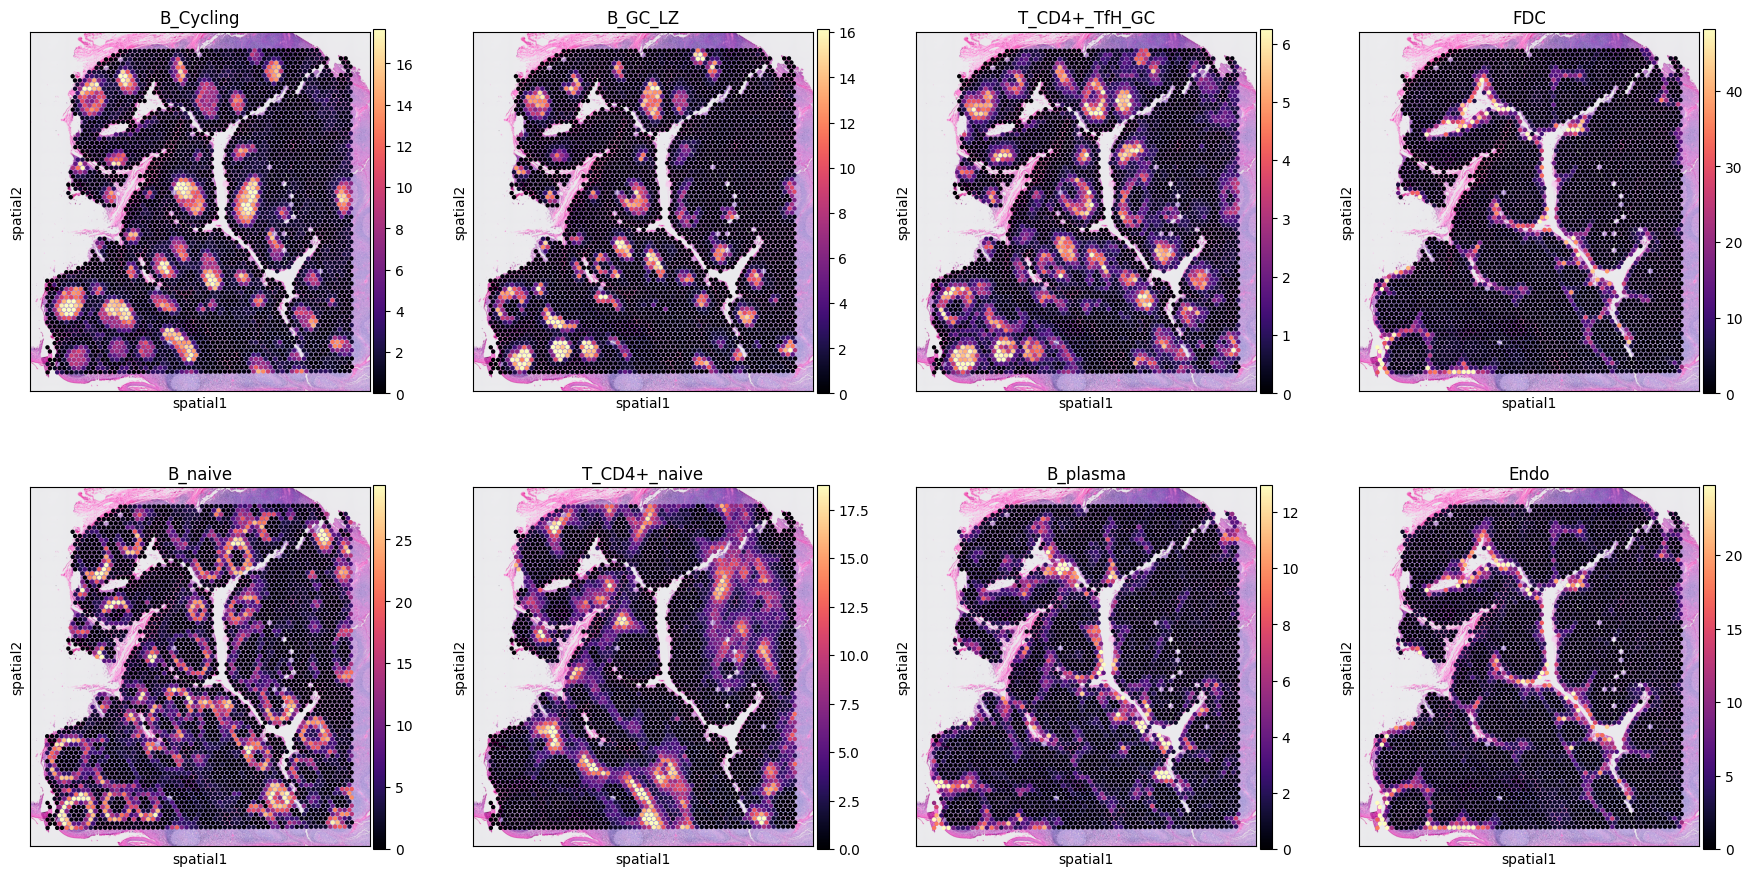

In [24]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'CytAssist_FFPE_Protein_Expression_Human_Tonsil')
    
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    
    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'], 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2' 
                 )

In [29]:
sc.pp.neighbors(
    adata_vis, 
    use_rep='q05_cell_abundance_w_sf',
    n_neighbors = 15
)

sc.tl.leiden(adata_vis, resolution=0.5)

In [27]:
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

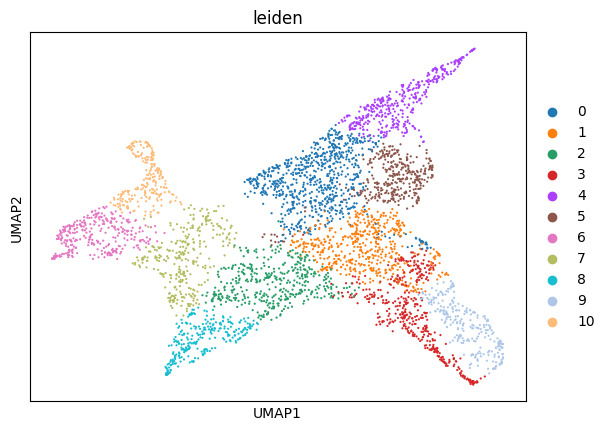

In [30]:
sc.pl.umap(adata_vis, color='leiden', s=10)

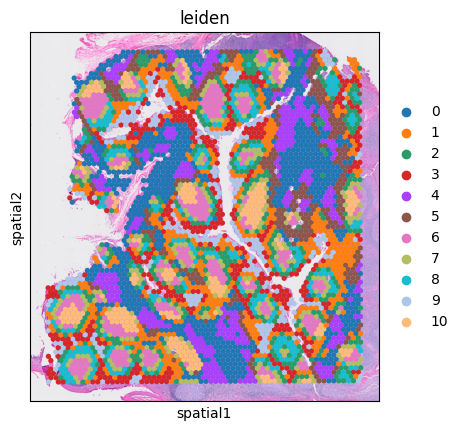

In [31]:
sc.pl.spatial(adata_vis, color='leiden', s=10)

In [69]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis, 
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(10, 25), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample           
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'/tmp/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_4194locations_34factors
### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_4194locations_34

In [71]:
res_dict.keys()

dict_keys(['n_fact10', 'n_fact11', 'n_fact12', 'n_fact13', 'n_fact14', 'n_fact15', 'n_fact16', 'n_fact17', 'n_fact18', 'n_fact19', 'n_fact20', 'n_fact21', 'n_fact22', 'n_fact23', 'n_fact24'])

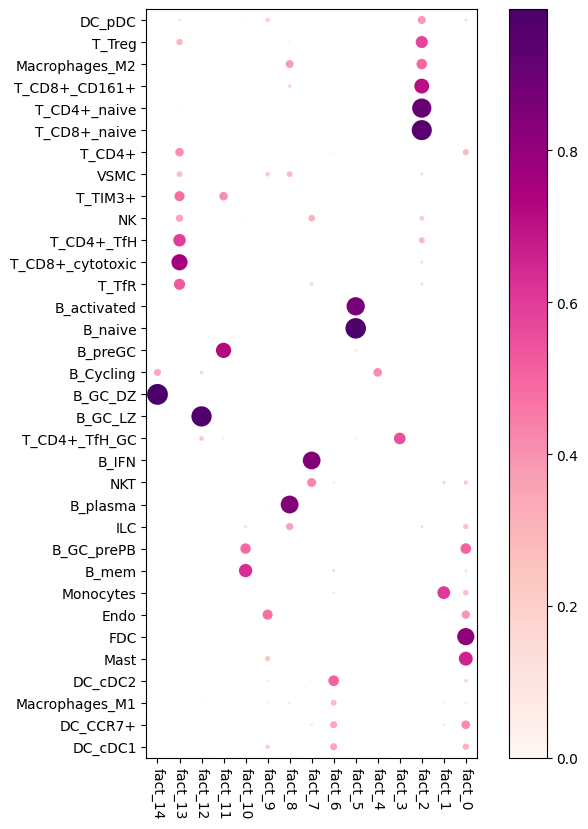

In [76]:
res_dict['n_fact15']['mod'].plot_cell_type_loadings()

In [95]:
factors2regions = {
    0:'DC',
    1:'Monocytes',
    2:'Naive T cells',
    3:'Tfh',
    4:'GC Dark Zone',
    5:'Naive B cells',
    6:'DC',
    7:'B cells',
    8:'Plasma B cells',
    9:'DC',
    10:'Memory B cells',
    11:'preGC B cells',
    12:'GC Light Zone',
    13:'CD8+ T cells',
    14:'GC Dark Zone',
}

In [59]:
import pandas as pd

In [96]:
adata_vis = res_dict['n_fact15']['mod'].annotate_adata(adata_vis) # as columns to .obs
adata_vis = res_dict['n_fact15']['mod'].export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns
res_dict['n_fact15']['mod'].sample2df()

In [103]:
adata_vis.obs['cell_type'] = pd.DataFrame(adata_vis.uns['mod_sklearn']['post_sample_means']['location_factors']).iloc[:, :].idxmax(axis=1).replace(factors2regions).values
adata_vis.obs['cell_type'] = adata_vis.obs['cell_type'].astype('category')

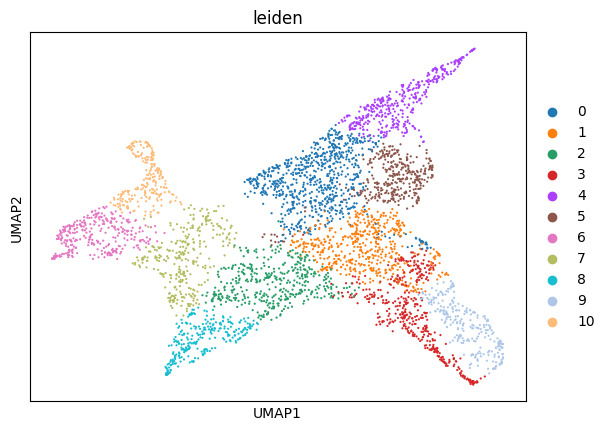

In [104]:
sc.tl.leiden(adata_vis, resolution=0.5)
sc.pl.umap(adata_vis, color='leiden', s=10)

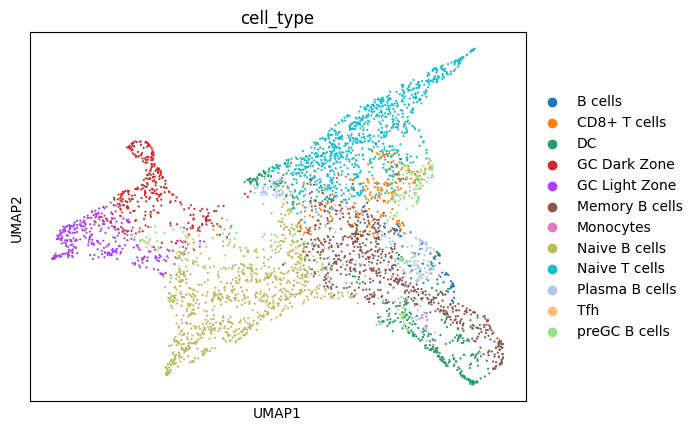

In [105]:
sc.pl.umap(adata_vis, color='cell_type', s=10)

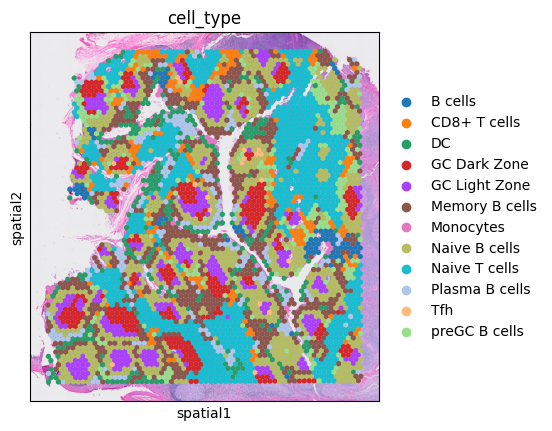

In [106]:
sc.pl.spatial(adata_vis, color='cell_type', s=10)

In [108]:
adata_vis.obs[['cell_type']].to_csv('cell2location_cell_types.csv')

In [109]:
# adata.write_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')